In [156]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import glob
import tqdm

### Prepare Data

In [157]:
folder_path = '/Users/xuzhaozhong/Downloads/jets'
x_train = []
y_train = []

for i in tqdm.trange(30000):
    formatted_i = "{:07}".format(i)
    file_path = f"{folder_path}/event_{formatted_i}.npz"  # Adjust the file extension if needed
    with np.load(file_path) as event:
        x_train.append(event['x'])
        y_train.append(event['y'])

100%|███████████████████████████████████| 30000/30000 [00:14<00:00, 2128.81it/s]


In [158]:
x_train_padded = []

for i in tqdm.trange(len(x_train)):
    padded_item = np.zeros((200, 5))
    num_rows = x_train[i].shape[0]

    # Copy the original data into the padded_item
    padded_item[:num_rows, :] = x_train[i]

    x_train_padded.append(padded_item)

x_train_padded_array = np.array(x_train_padded)



100%|█████████████████████████████████| 30000/30000 [00:00<00:00, 532310.36it/s]


In [159]:
x_train = x_train_padded_array
y_train = np.array(y_train)

In [160]:
x_train = x_train.reshape(-1,200*5)
print(x_train.shape)

(30000, 1000)


In [161]:
# Scale the dataset according to standard scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_train = x_train.reshape(-1, 1, 200, 5)
print(x_train.shape)

(30000, 1, 200, 5)


In [162]:
x_test = x_train[25000:len(x_train)]
y_test = y_train[25000:len(x_train)]
x_validation=x_train[20000:25000]
y_validation=y_train[20000:25000]
x_train = x_train[:20000]
y_train = y_train[:20000]
print(x_train.shape,y_train.shape,x_test.shape)

(20000, 1, 200, 5) (20000, 5) (5000, 1, 200, 5)


### Define Model

In [163]:
class CNNModel(torch.nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.cnn1 = torch.nn.Conv2d(in_channels=1,out_channels=32,kernel_size=9,stride=1,padding=4)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.cnn2 = torch.nn.Conv2d(in_channels=32,out_channels=64,kernel_size=9,stride=1,padding=4)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(64*50*1,5)

    def forward(self, x):
        conv1_out = torch.nn.functional.relu(self.cnn1(x))
        pool1_out = self.maxpool1(conv1_out)
        
        conv2_out = torch.nn.functional.relu(self.cnn2(pool1_out))
        pool2_out = self.maxpool2(conv2_out)
        
        fc1_input = pool2_out.view(pool2_out.size(0),-1)
        out = self.fc1(fc1_input)
        return out


### Define Hyperparameters

In [164]:
# Initialize our neural network model with input and output dimensions
model = CNNModel()
device = torch.device( "mps"if torch.backends.mps.is_available else"cpu")
#device = torch.device("cpu")
# Define the learning rate and epoch 
learning_rate = 0.001
epochs = 50
batchsize = 2000#(If you are using mini-batch gradient)

# Define loss function and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate,weight_decay=0.01)
model.to(device)

CNNModel(
  (cnn1): Conv2d(1, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(32, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3200, out_features=5, bias=True)
)

### Identify Tracked Values

In [165]:
validation_accuracy_list = []
train_loss_list = []

### Train Model

In [166]:
import tqdm # For keeping track of our training progress in percentage

# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors

train_inputs = torch.from_numpy(x_train).float().to(device)
train_targets = torch.from_numpy(y_train).long().to(device) # Convert to 64-bit integer
x_batch_train = torch.split(train_inputs, batchsize)
y_batch_train = torch.split(train_targets, batchsize)
batch_split_num = len(x_batch_train)

validation_inputs = torch.from_numpy(x_validation).float().to(device)
validation_targets = torch.from_numpy(y_validation).long().to(device)

testing_inputs = torch.from_numpy(x_test).float().to(device)
testing_targets = torch.from_numpy(y_test).long().to(device)

# Training Loop ---------------------------------------------------------------------------------------

iteration = 0
for epoch in range(epochs):  
    for i in range(batch_split_num):
        optimizer.zero_grad() # Empty the gradient buffer so each learning event per epoch is separate

        outputs = model(x_batch_train[i]) # Forward pass the inputs through the network to produce outputs 
        
        y_batch_indices = torch.argmax(y_batch_train[i], dim=1)

        loss = loss_func(outputs, y_batch_indices) # Compute the loss via comparing the output with expected targets
    
        train_loss_list.append(loss.item()) # Save the loss value to train_loss_list we defined
    
        loss.backward() # Compute how much changes to be made to weights/biases

        optimizer.step() # Update the weights/biases according to learning rate
        
        outputs = model(validation_inputs)
        
        _, predicted = torch.max(outputs, 1)# Find the index  with the highest probability for each sample
        
        correct = (predicted == torch.argmax(validation_targets, dim=1)).sum().item()
        
        total = validation_targets.size(0)
        
        accuracy = correct / total
        
        validation_accuracy_list.append(accuracy)  

    print("Averaged Training Loss for Epoch ", epoch,": ", np.mean(train_loss_list[-batch_split_num:]))



Averaged Training Loss for Epoch  0 :  1.4119691729545594
Averaged Training Loss for Epoch  1 :  1.1541939616203307
Averaged Training Loss for Epoch  2 :  1.0448987185955048
Averaged Training Loss for Epoch  3 :  0.9749958515167236
Averaged Training Loss for Epoch  4 :  0.9392392992973327
Averaged Training Loss for Epoch  5 :  0.9144829630851745
Averaged Training Loss for Epoch  6 :  0.8973813772201538
Averaged Training Loss for Epoch  7 :  0.8851095914840699
Averaged Training Loss for Epoch  8 :  0.876237541437149
Averaged Training Loss for Epoch  9 :  0.8684121608734131
Averaged Training Loss for Epoch  10 :  0.8605201601982116
Averaged Training Loss for Epoch  11 :  0.8557437062263489
Averaged Training Loss for Epoch  12 :  0.8510582983493805
Averaged Training Loss for Epoch  13 :  0.8462850034236908
Averaged Training Loss for Epoch  14 :  0.8423600614070892
Averaged Training Loss for Epoch  15 :  0.837714421749115
Averaged Training Loss for Epoch  16 :  0.8335491359233856
Averaged 

In [167]:
with torch.no_grad():
    outputs = model(validation_inputs)
    _, predicted = torch.max(outputs, 1)# Find the index  with the highest probability for each sample
    correct = (predicted == torch.argmax(validation_targets, dim=1)).sum().item()
    total = validation_targets.size(0)
    accuracy = correct / total
    print('Accuracy: {:.2f}'.format(accuracy))

Accuracy: 0.73


### Visualize and Evaluate Model

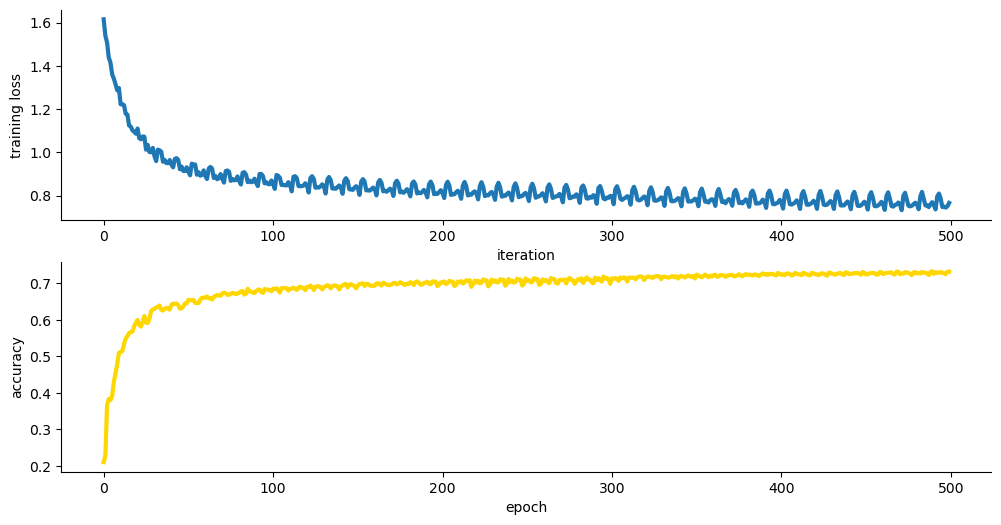

In [168]:
# Import seaborn for prettier plots

import seaborn as sns
# Visualize training loss

plt.figure(figsize = (12, 6))

# Visualize training loss with respect to iterations (1 iteration -> single batch)
plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("iteration")
sns.despine()

# Visualize validation accuracy with respect to epochs
plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("accuracy")
plt.xlabel("epoch")
sns.despine()

In [169]:
# Compute the testing accuracy 

with torch.no_grad():        
    outputs = model(testing_inputs)
    
    correct = (torch.argmax(outputs, dim=1) == torch.argmax(testing_targets,dim=1)).type(torch.FloatTensor).to(device)
    
    test_accuracy = correct.mean().item()
    print('Testing accuracy: {:.4f}'.format(test_accuracy))

Testing accuracy: 0.7328


In [170]:
# Define class names for your problem
class_names = ['Gluon', 'Light quark', 'W boson', 'Z boson', 'Top quark']

# Initialize an empty list to store the accuracy for each class
accuracy_1 = []

# Calculate the accuracy for each class
for i in range(5):
    # Find the indices of the samples in the testing set that belong to class i
    index = np.where(torch.argmax(testing_targets,dim=1).cpu().numpy() == i)[0]
    # Compute the accuracy for class i
    class_correct = (torch.argmax(outputs[index], dim=1) == i).type(torch.FloatTensor).to(device)
    accuracy_1.append(class_correct.mean().item())
    # Print out the accuracy for class i
    print('Accuracy of {}: {:.2f}%'.format(class_names[i], accuracy_1[i] * 100))
    
# Find the class that the model had the hardest time classifying
hardest_class = class_names[np.argmin(accuracy_1)]
print('The class that the model had the hardest time classifying is: {}'.format(hardest_class))


Accuracy of Gluon: 69.02%
Accuracy of Light quark: 66.53%
Accuracy of W boson: 78.45%
Accuracy of Z boson: 72.31%
Accuracy of Top quark: 79.73%
The class that the model had the hardest time classifying is: Light quark


In [171]:
for i in range(5):
    # Find the indices of the samples in the testing set that belong to class i
    class_proportion = (torch.argmax(train_targets, dim=1) == i).type(torch.FloatTensor).to(device).mean().item()
    # Print out the proportion for class i
    print('Proportion of {}: {:.2f}%'.format(class_names[i], class_proportion * 100))

Proportion of Gluon: 20.23%
Proportion of Light quark: 19.92%
Proportion of W boson: 20.05%
Proportion of Z boson: 19.77%
Proportion of Top quark: 20.03%
